In [41]:
import numpy as np
# import third-party libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import datetime


In [105]:
# The parameters:

sigma_annually = 0.30

# 252 trading days in a year
sigma_daily = sigma_annually / np.sqrt(252)

# There are 6.5 trading hours per trading day:
sigma_hourly = sigma_daily / np.sqrt(6.5)

sigma_30min = sigma_hourly/ np.sqrt(2)
sigma_10min = sigma_hourly/ np.sqrt(6)
N_30min = 14
N_10min = 40

gamma = 1
mu = 0
lamb = 1e-4
nr_shares = 1e6
rho = 1

def trading_day_Qqc(T, totalT, sigma, lunch_break):
    cur_lamb = lamb
    if lunch_break:
        time = (T - 1)/(totalT - 1)
        if time >= 2.5/6.5 and time <= 4.5/6.5:
            # How about a Tuna Fish sandwich?
            cur_lamb = 2*lamb
    if(T == 1):
        Qt = gamma * sigma**2 * cur_lamb / (cur_lamb + gamma * sigma**2)
        qt = cur_lamb * mu / (cur_lamb + gamma * sigma**2)
        ct = mu**2 / (2 * (cur_lamb + gamma * sigma**2))
        return [(Qt, qt, ct)]
    else:
        # I recurse
        list = trading_day_Qqc(T - 1, totalT, sigma, lunch_break);
        Qt1, qt1, ct1 = list[0];
        
        Qt = (gamma * sigma**2 + rho * Qt1)*cur_lamb / (cur_lamb + gamma*sigma**2 + rho * Qt1)
        qt = cur_lamb*(mu + rho * qt1) / (cur_lamb + gamma * sigma**2 + rho * Qt1)
        ct = (mu + rho * qt1)**2 / 2*(cur_lamb + gamma * sigma**2 + rho * Qt1) + rho*ct1
        list.insert(0, (Qt, qt, ct));
        return list

def trading_history(totalT, nr_shares, sigma, lunch_break):
    day = trading_day_Qqc(totalT, totalT, sigma, lunch_break)
    
    # In the beginning there was the nr_shares and no trading cost
    n = [(nr_shares, 0)]
    cur_lamb = lamb
    for i in range(1, totalT):
        if lunch_break:
            time = (i - 1)/(totalT - 1)
            if time >= 2.5/6.5 and time <= 4.5/6.5:
                # Parmentier?
                #print(lunch_break.__str__() + " lunch " + totalT.__str__())
                cur_lamb = 2*lamb
        Qt, qt, ct = day[i]
        n_new = (mu + cur_lamb * n[-1][0] + rho*qt) / (cur_lamb + gamma*sigma**2 + rho*Qt)
        cost_new = lamb * (n_new - n[-1][0])**2
        n.append((n_new, cost_new + n[-1][1]))
        
    return n

n_30_nolunch = trading_history(N_30min, nr_shares, sigma_30min, lunch_break=0)
n_30_yeslunch = trading_history(N_30min, nr_shares, sigma_30min, lunch_break=1)
n_10_nolunch = trading_history(N_10min, nr_shares, sigma_10min, lunch_break=0)
n_10_yeslunch = trading_history(N_10min, nr_shares, sigma_10min, lunch_break=1)


1 lunch 14
1 lunch 14
1 lunch 14
1 lunch 14
1 lunch 14
1 lunch 40
1 lunch 40
1 lunch 40
1 lunch 40
1 lunch 40
1 lunch 40
1 lunch 40
1 lunch 40
1 lunch 40
1 lunch 40
1 lunch 40
1 lunch 40
1 lunch 40


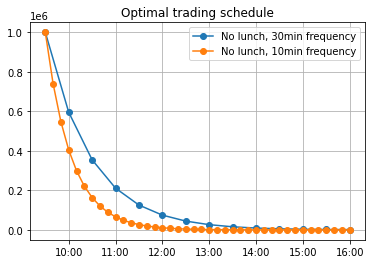

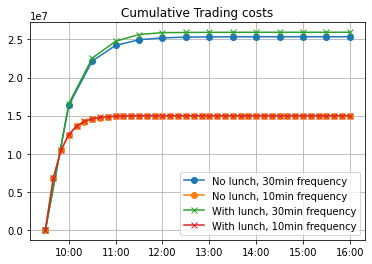

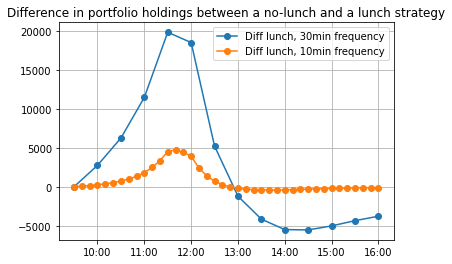

In [110]:
#  No Lunch
n_30, cost_30 = map(list, zip(*n_30_nolunch))
n_10, cost_10 = map(list, zip(*n_10_nolunch))

n_30_lunch, cost_30_lunch = map(list, zip(*n_30_yeslunch))
n_10_lunch, cost_10_lunch = map(list, zip(*n_10_yeslunch))

n_30 = np.array(n_30)
n_30_lunch = np.array(n_30_lunch)
n_10 = np.array(n_10)
n_10_lunch = np.array(n_10_lunch)

fig, ax = plt.subplots()

timemin = datetime.datetime(2020, 5, 4, 9, 30)
times_30min = [timemin + datetime.timedelta(minutes=30*i) for i in range(N_30min)]
times_10min = [timemin + datetime.timedelta(minutes=10*i) for i in range(N_10min)]

ax.format_xdata = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.plot_date(times_30min, n_30, '-o', label = 'No lunch, 30min frequency')
ax.plot_date(times_10min, n_10, '-o', label = 'No lunch, 10min frequency')
ax.set_title('Optimal trading schedule')
#ax.plot_date(times_30min, n_30_lunch, '-o', label = 'With lunch, 30min frequency')
#ax.plot_date(times_10min, n_10_lunch, '-o', label = 'With lunch, 10min frequency')
ax.legend()
ax.grid(True)
plt.savefig('fig1.pdf')


fig, ax = plt.subplots()

ax.format_xdata = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.plot_date(times_30min, cost_30, '-o', label = 'No lunch, 30min frequency')
ax.plot_date(times_10min, cost_10, '-o', label = 'No lunch, 10min frequency')
ax.set_title('Cumulative Trading costs')
ax.plot_date(times_30min, cost_30_lunch, '-x', label = 'With lunch, 30min frequency')
ax.plot_date(times_10min, cost_10_lunch, '-x', label = 'With lunch, 10min frequency')
ax.legend()
ax.grid(True)
plt.savefig('fig2.pdf')

fig, ax = plt.subplots()
ax.format_xdata = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.plot_date(times_30min, n_30 - n_30_lunch, '-o', label = 'Diff lunch, 30min frequency')
ax.plot_date(times_10min, n_10 - n_10_lunch, '-o', label = 'Diff lunch, 10min frequency')
ax.set_title('Difference in portfolio holdings between a no-lunch and a lunch strategy')
#ax.plot_date(times_30min, n_30_lunch, '-o', label = 'With lunch, 30min frequency')
#ax.plot_date(times_10min, n_10_lunch, '-o', label = 'With lunch, 10min frequency')
ax.legend()
ax.grid(True)
plt.savefig('fig3.pdf')
plt.show()
